In [39]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import r2_score, accuracy_score

# Para gerar a imagem da árvore
from sklearn.tree import export_graphviz
from subprocess import call

# Para visualizar a imagem
from IPython.display import Image

In [40]:
df_candidatos = pd.read_csv("database_candidatos.csv", encoding="utf-8", header=1)
df_notas_candidatos = pd.read_csv("notas_candidatos.csv", encoding="utf-8")

In [41]:
def get_data(range_tuple: tuple[int, int], column_name: str) -> tuple:
    """  Retorna o conjunto de dados
    Retorna-se o conjunto de dados no intervalo e da coluna informada.

    Parâmetros
    ----------
    range_tuple: 
        Tupla contendo o valor inicial e final das colunas que serão
        utilizadas do conjunto de dados.
    column_name:
        String com o nome da coluna das notas que será utilizada como
        a matriz de valores verdadeiros.

    Retorno
    -------
    Tupla contendo a matrizes X e y do conjunto de dados.
    """
    a, b = range_tuple
    idx = df_notas_candidatos.loc[:, "aprovado"] != "?"
    # Copia os dados requisitados
    X = df_candidatos[idx].copy().iloc[:, a:b]
    y = df_notas_candidatos[idx].copy()[column_name]

    return X, y

In [42]:
def evaluate(
    X: np.ndarray, y: np.ndarray, classifier = None,
    n_splits: int = 5, shuffle: bool = True, random_state: int = 42
) -> float:
    """  Retorna o score R2 do conjunto de dados.
    Retorna a média do score R2 gerado por um regressor linear para
    o conjunto de dados informado. Utiliza-se uma validação cruzada
    para aproveitar todos dados disponíveis.

    Parâmetros
    ----------
    X: 
        Matriz de features.
    y:
        Matriz com as notas finais correspondente a matriz X.
    classifier:
        Classificador utilizado.
    n_splits:
        Número de folds utilizados no K-Fold.
    shuffle:
        True para embaralhar os dados. False, caso contrário.
    random_state:
        Seed para tornar reprodutível.

    Retorno
    -------
    Média dos scores R2 de cada rodada de teste da validação cruzada.
    """
    cv = KFold(n_splits=n_splits, shuffle=shuffle, random_state=random_state)
    clf = LinearRegression(n_jobs=-1) if classifier is None else classifier
    data = cross_validate(clf, X, y, cv=cv, scoring="r2", n_jobs=-1)
    
    return data["test_score"].mean()

# Notas Trabalho

#### Ajustando um regressor linear no conjunto para os dados de nota_trabalho. Utilizando o LabelEncoder para transformar as strings do conjunto de dados em números.

In [43]:
X, y = get_data((3, 7), "nota_trabalho")

In [44]:
for index, column in enumerate(X):
    X.iloc[:, index] = LabelEncoder().fit_transform(X.iloc[:, index])

In [45]:
X = X.to_numpy().astype(np.int8)
y = y.to_numpy().astype(np.float32)

In [46]:
score = evaluate(X, y)
print(f"Average R2: {score * 100:.2f}%")

Average R2: 100.00%


# Nota Inglês

#### Ajustando um regressor linear para os dados de nota_trabalho. Ainda utilizando o LabelEncoder.

In [47]:
X, y = get_data((7, 11), "nota_ingles")

In [48]:
for index, column in enumerate(X):
    X.iloc[:, index] = LabelEncoder().fit_transform(X.iloc[:, index])

In [49]:
X = X.to_numpy().astype(np.float32)
y = y.to_numpy().astype(np.float32)

In [50]:
score = evaluate(X, y)
print(f"Average R2: {score * 100:.2f}%")

Average R2: 14.54%


# Utilizando One Hot Encoder

#### Alternativa para eliminar o viés os dados.

In [51]:
X, y = get_data((7, 11), "nota_ingles")
X = OneHotEncoder().fit_transform(X).toarray()
y = y.to_numpy().astype(np.float32)

In [52]:
score = evaluate(X, y)
print(f"Average R2: {score * 100:.2f}%")

Average R2: 100.00%


# Nota Profissional

#### Ajustando o regressor linear para nota_profissional utilizando o OneHotEncoder.

In [53]:
X, y = get_data((11, 19), "nota_profissional")
X = OneHotEncoder().fit_transform(X).toarray()
y = y.to_numpy().astype(np.float32)

In [54]:
score = evaluate(X, y)
print(f"Average R2: {score * 100:.2f}%")

Average R2: 98.83%


## Erro pela quantidade de dados

#### Com o conjunto de dados completo vemos que conseguimos reproduzir todas entradas, isto é, ainda que analisar o score R2 predizendo o próprio conjunto seja incorreto, conseguimos ver que o regressor ajusta os pesos perfeitamente aos dados, indicando uma possível falta de amostras ao utilizarmos a validação cruzada.

In [55]:
clf = LinearRegression(n_jobs=-1).fit(X, y)
pred = clf.predict(X)
print(f"R2 Score: {r2_score(y, pred) * 100:.2f}%")

R2 Score: 100.00%


# Nota Ferramentas

In [56]:
X, y = get_data((19, 44), "nota_ferramentas")
X = OneHotEncoder().fit_transform(X).toarray()
y = y.to_numpy().astype(np.float32)

In [57]:
score = evaluate(X, y)
print(f"Average R2: {score * 100:.2f}%")

Average R2: 94.82%


## Mesmo erro de quantidade

In [58]:
clf = LinearRegression(n_jobs=-1).fit(X, y)
pred = clf.predict(X)
print(f"R2 Score: {r2_score(y, pred) * 100:.2f}%")

R2 Score: 100.00%


# Nota Algoritmos

In [59]:
X, y = get_data((44, 57), "nota_algoritmos")
X = OneHotEncoder().fit_transform(X).toarray()
y = y.to_numpy().astype(np.float32)

In [60]:
score = evaluate(X, y)
print(f"Average R2: {score * 100:.2f}%")

Average R2: 99.49%


## Erro de quantidade

In [61]:
clf = LinearRegression(n_jobs=-1).fit(X, y)
pred = clf.predict(X)
print(f"{r2_score(y, pred) * 100:.2f}%")

100.00%


# Preenchendo Notas Faltantes

#### Cria-se um regressor linear para cada conjunto de dados(tipo de nota), ajustando-o no conjunto de dados e utilizando para encontrar os valores que faltam.

In [62]:
splits = [(3, 7), (7, 11), (11, 19), (19, 44), (44, 57)]

tags = [
    f"nota_{x}"
    for x in ["trabalho", "ingles", "profissional", "ferramentas", "algoritmos"]
]

In [63]:
# Para cada coluna ajustamos um regressor e geramos os dados que faltam. 

for i, tag in enumerate(tags):
    idx = df_notas_candidatos.loc[:, tag] == "?"
    train_index = ~idx
    
    # Separa os dados do tipo de nota analisada
    a, b = splits[i]
    X, y = df_candidatos[train_index].copy(), df_notas_candidatos[train_index].copy()
    X, y = X.iloc[:, a:b], y[tag]
    
    # Aplica o OneHotEncoder nas colunas
    categories = [
        ["Já_ouvi_Falar", "Nunca_nem_vi", "Já_trabalhei", "Tenho_domínio"]
        for _ in range(X.shape[1])
    ]
    oht = (
        OneHotEncoder().fit(X)
        if i != 3 # Para a coluna 3 utilizamos as categorias, pois falta uma delas no fit
        else OneHotEncoder(categories=categories).fit(X)
    )
    X = oht.transform(X).toarray()
    y = y.to_numpy().astype(np.float32)
    
    # Criamos o regressor
    clf = LinearRegression(n_jobs=-1).fit(X, y)
    
    # Geramos os dados com o regressor
    for index, line in df_notas_candidatos[idx].iterrows():
        sample = df_candidatos.iloc[index, a:b].copy()
        sample = np.expand_dims(sample.to_numpy(), 0)
        sample = oht.transform(sample).toarray()
        pred = np.around(clf.predict(sample), 4)
        df_notas_candidatos.loc[index, tag] = pred

In [64]:
# Calcula a nota_final(Média de todas as notas).

idx = df_notas_candidatos.loc[:, "nota_Final"] == "?"

for index, linha in df_notas_candidatos[idx].iterrows():
    df_notas_candidatos.loc[index, "nota_Final"] = df_notas_candidatos.iloc[
        index, 2:7
    ].mean()

In [65]:
""" A matriz X será todos notas finais, enquanto que a matriz
y será a se a pessoa foi aprovada ou não. """

idx = df_notas_candidatos.loc[:, "aprovado"] != "?"

X_train, y_train = (
    df_notas_candidatos[idx].loc[:, "nota_Final"],
    df_notas_candidatos[idx].loc[:, "aprovado"],
)

y_train = [1 if value == "True" else 0 for value in y_train]
X_train = np.expand_dims(X_train.to_numpy(), axis=1)

In [66]:
# Vendo se o Random Forest consegue prever todos dados do cojunto de treino.

clf = RandomForestClassifier(n_jobs=-1)
cv = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_validate(clf, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1)['test_score']
print(f"Accuracy: {scores.mean() * 100:.2f}%")

Accuracy: 97.78%


In [67]:
""" Ainda que não tenha sido 100%, vemo que foi devido a apenas uma rodada,
utilizando todo conjunto isso não ocorre. """

print(f"Scores: {scores}")
clf = RandomForestClassifier().fit(X_train, y_train)
pred = clf.predict(X_train)
print(f"Accuracy: {accuracy_score(y_train, pred) * 100:.2f}%")

Scores: [1.         1.         1.         1.         0.88888889]
Accuracy: 100.00%


In [68]:
idx = ~idx

for index, linha in df_notas_candidatos[idx].iterrows():
    sample = np.array([df_notas_candidatos.iloc[index, -2].copy()])
    sample = sample.reshape(-1, 1)
    df_notas_candidatos.loc[index, "aprovado"] = (
        True if clf.predict(sample) == 1 else False
    )

In [69]:
%%capture
# Escolhendo uma árvore aleatória
np.random.seed(42)
estimator = clf.estimators_[np.random.choice(100)]

# Exportando o arquivo .dot
export_graphviz(
    estimator,
    out_file="tree.dot",
    rounded=True,
    proportion=False,
    precision=2,
    filled=True,
)

# Convertendo .dot para .png (requer Graphviz instalado)
call(["dot", "-Tpng", "tree.dot", "-o", "tree.svg", "-Gdpi=600"])

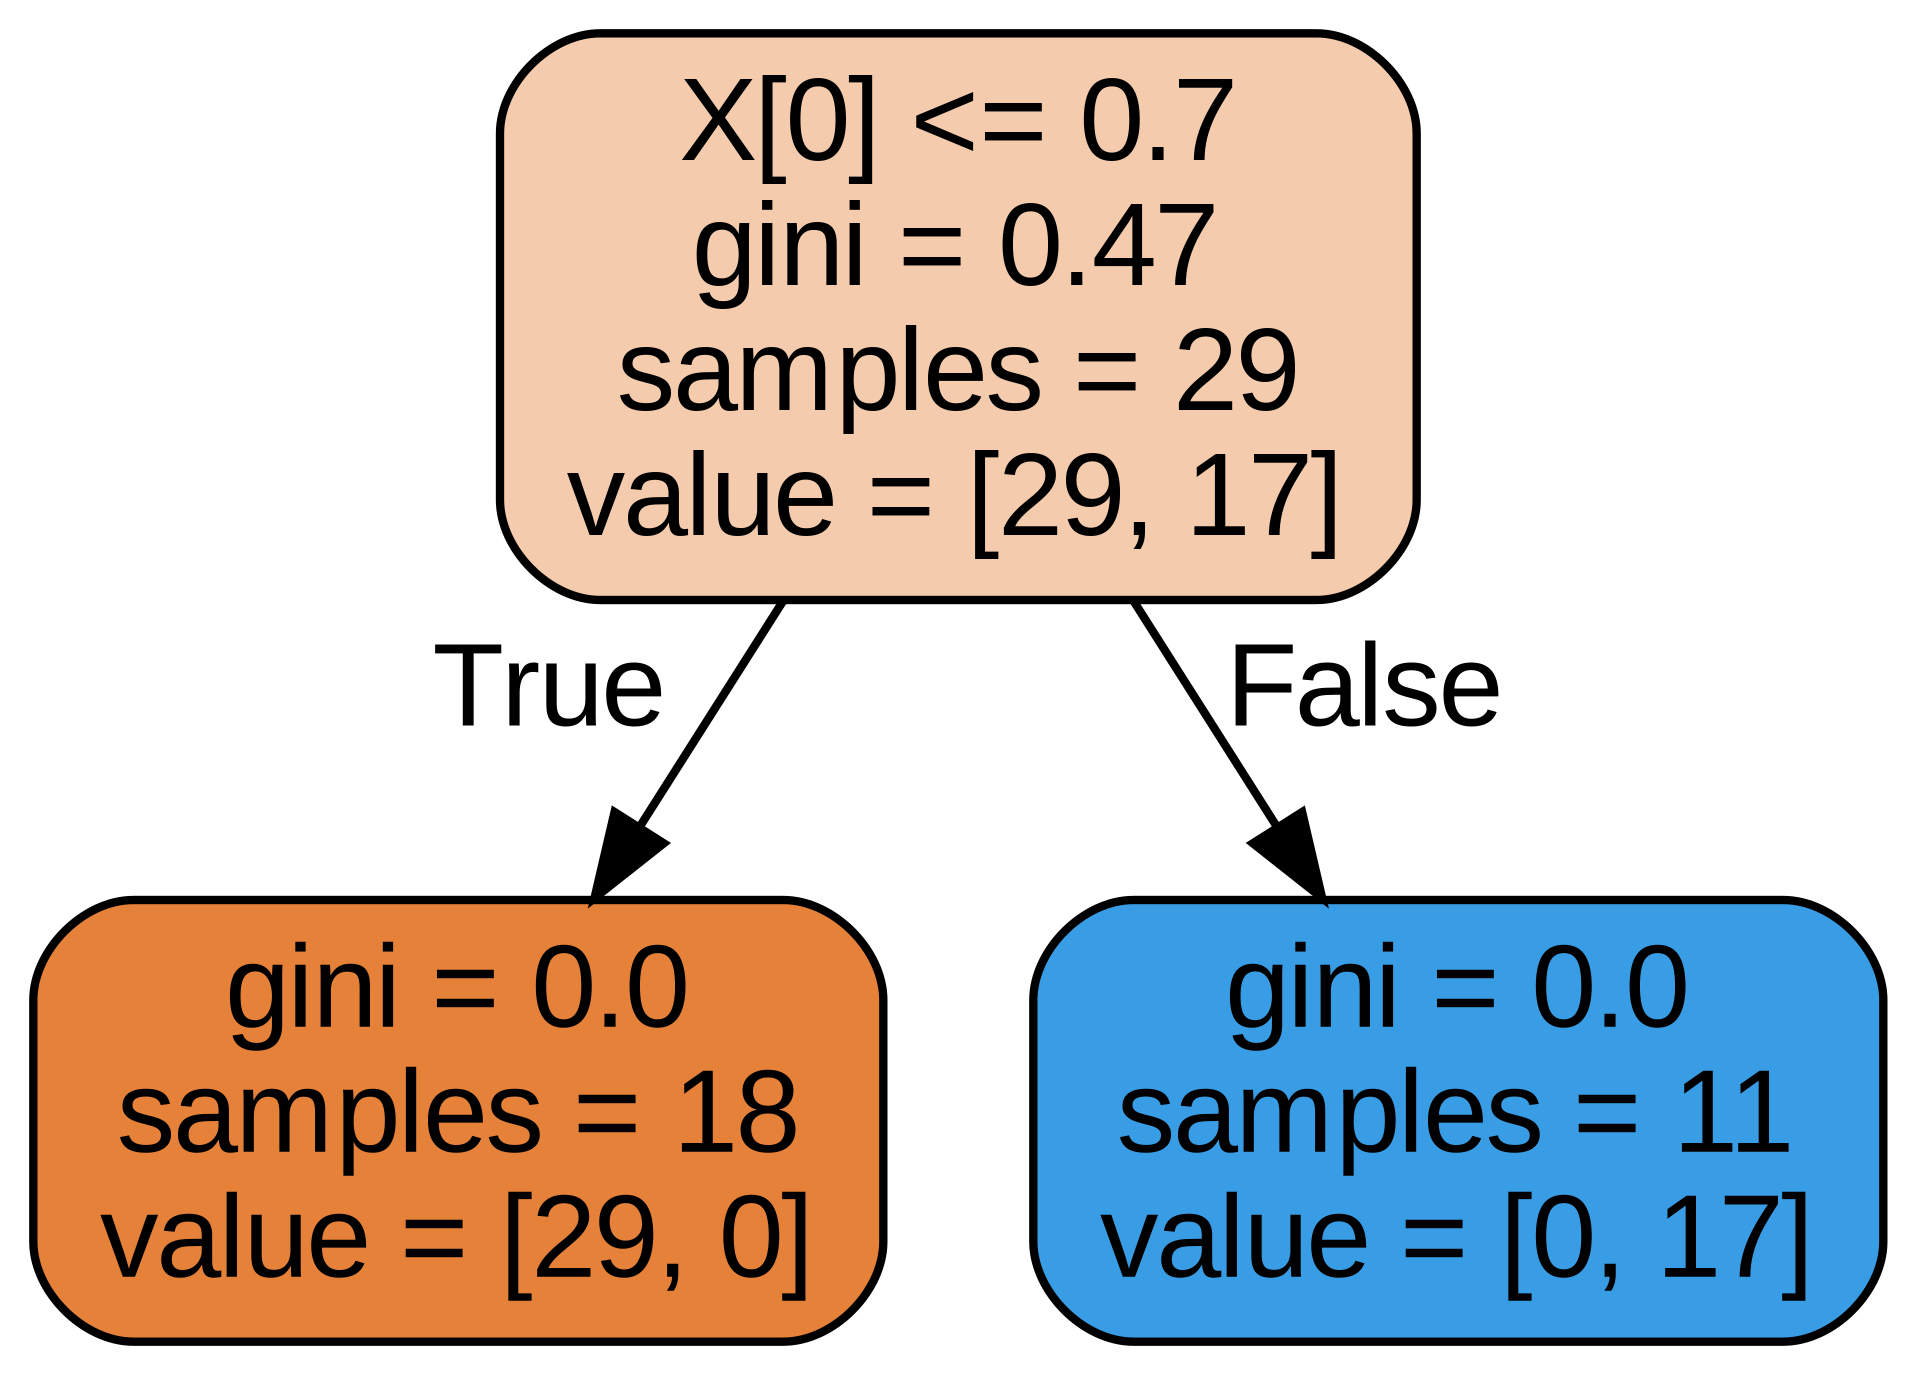

In [70]:
Image(filename='tree.png', width=400)